## Indicators of forecast uncertainty

So far, we have looked at two metrics derived from weather forecasts that seem like decent indicators of power forecast uncertainty. Now, we will look a little more closely at those for the sample days we have been looking at. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Let's load our earlier profiles:
- day-ahead forecasted power based on the coarsened HRRR
- forecasted power based on max and min from the coarsened HRRR
- normalized "max-min" range
- weighted average TCC from GEFS
- modeled actual power (from HRRR)
- modeled clear sky power

In [2]:
p_ac_hrrr_coarse_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_all.pkl')
p_ac_hrrr_coarse_max_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_max_all.pkl')
p_ac_hrrr_coarse_min_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_min_all.pkl')
max_min_norm = pd.read_pickle('example_data/max_min_norm_20210408.pkl')
weighted_avg_tcc = pd.read_pickle('example_data/weighted_avg_tcc_20210408.pkl')

power_ac_cs_all = pd.read_pickle('example_data/power_ac_cs_all.pkl')
p_ac_hrrr_actuals_all = pd.read_pickle('example_data/p_ac_hrrr_actuals_all.pkl')

As a reminder, here's a plot of actual and forecasted power, along with clear sky and the max-min range for reference:

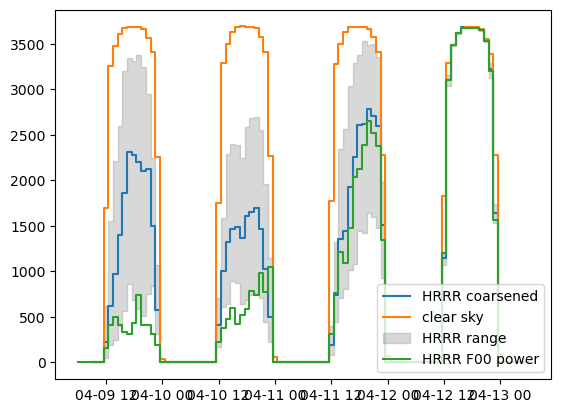

In [3]:
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])

plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power')
plt.legend(loc='lower right')
plt.show()

Now, let's look at actuals and forecasts with the two uncertainty indicators we developed earlier:
1. the standard deviation of weighted average TCC from GEFS
2. range of max and min power from HRRR, normalized to clear sky power

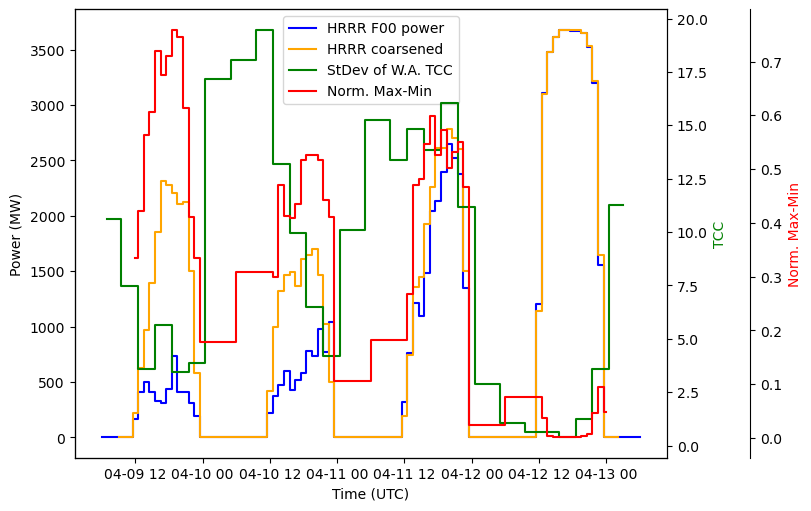

In [4]:
# Based on https://stackoverflow.com/a/45925049
fig, ax1 = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches

ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("TCC")
ax3.set_ylabel("Norm. Max-Min")

p1 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power',
         color='blue',
         )

p2 = ax1.plot(p_ac_hrrr_coarse_all.index,
              p_ac_hrrr_coarse_all.power_ac,
              drawstyle='steps-mid',
              label='HRRR coarsened',
              color='orange',
              )

p3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. TCC', color='green')

p4 = ax3.plot(max_min_norm.index, max_min_norm.max_min_norm, drawstyle='steps-mid',
         label='Norm. Max-Min', color='red')

ax1.legend(handles=p1+p2+p3+p4, loc='upper center')

# right, left, top, bottom
ax3.spines['right'].set_position(('outward', 60))

ax2.yaxis.label.set_color(p3[0].get_color())
ax3.yaxis.label.set_color(p4[0].get_color())

The chart is a bit busy, but if we compare the first three days with the last one, we can see that there is a very loose correlation between forecast error and our two uncertainty indicators. 

Rename the `power_ac` column in all the power dataframes:

In [5]:
p_ac_hrrr_coarse_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_all'}, inplace=True)
p_ac_hrrr_coarse_max_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_max_all'}, inplace=True)
p_ac_hrrr_coarse_min_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_min_all'}, inplace=True)
power_ac_cs_all.rename(columns={'power_ac': 'power_ac_cs_all'}, inplace=True)
p_ac_hrrr_actuals_all.rename(columns={'power_ac': 'p_ac_hrrr_actuals_all'}, inplace=True)

Combine the dataframes:

In [6]:
# localize (assign timezone of UTC)
weighted_avg_tcc = weighted_avg_tcc.copy().tz_localize('UTC')

# list of dataframes to combiner first
dfs = [
    p_ac_hrrr_coarse_all,
    p_ac_hrrr_coarse_max_all,
    p_ac_hrrr_coarse_min_all,
    power_ac_cs_all,
    p_ac_hrrr_actuals_all,
    weighted_avg_tcc.tcc_std,
    ]

# combine all dataframes and drop na rows
df = pd.concat(dfs, axis=1).dropna()

# add max_min_norm
df = df.merge(max_min_norm, how='outer', left_index=True, right_index=True)

Calculate absolute error, normalized absolute error (normalized to max capacity), and clear sky normalized absolute error.

In [7]:
approx_nameplate = power_ac_cs_all.power_ac_cs_all.max() # use power_ac_cs_all.max() as proxy for nameplate rating
df['abs_err'] = (df.p_ac_hrrr_coarse_all - df.p_ac_hrrr_actuals_all).abs()
df['norm_abs_err'] = df.abs_err/approx_nameplate
df['cs_norm_abs_err'] = df.abs_err/df.power_ac_cs_all

Filter out periods where clear sky power is less than 1% of nameplate:

In [8]:
df[df.power_ac_cs_all < approx_nameplate*0.01] = np.nan

Scatter plot of clear sky normalized absolute error vs stadard deviation of weighted avg TCC and vs normalized min-max:

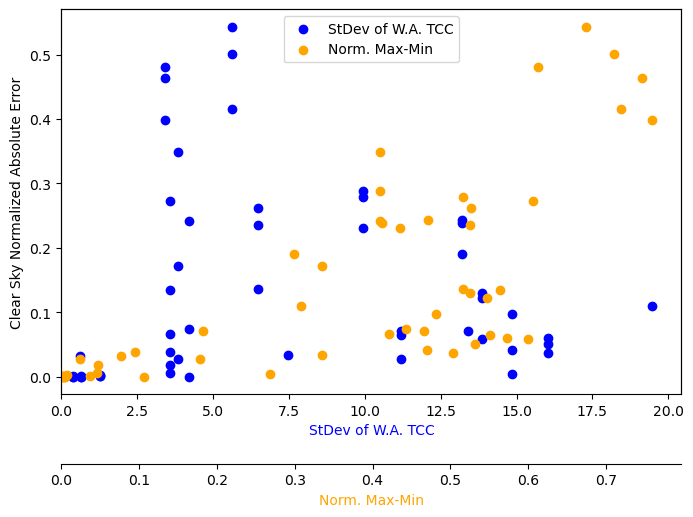

In [9]:
fig, ax1 = plt.subplots(figsize=(8,5)) # (width, height) in inches

ax2 = ax1.twiny()
    
ax1.set_ylabel("Clear Sky Normalized Absolute Error")
ax1.set_xlabel("StDev of W.A. TCC")
ax2.set_xlabel("Norm. Max-Min")

p1 = ax1.scatter(df.tcc_std, df.cs_norm_abs_err,
         label='StDev of W.A. TCC',
         color='blue',
         )

p2 = ax2.scatter(df.max_min_norm, df.cs_norm_abs_err,
         label='Norm. Max-Min', color='orange')

handles1,labels1 = ax1.get_legend_handles_labels()
handles2,labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2
labels = labels1 + labels2
ax1.legend(handles, labels, loc='upper center')

# ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax2.set_xlim(xmin=0)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# # right, left, top, bottom
ax2.spines['bottom'].set_position(('outward', 50))



ax1.xaxis.label.set_color(p1.get_facecolor())
ax2.xaxis.label.set_color(p2.get_facecolor())
plt.show()

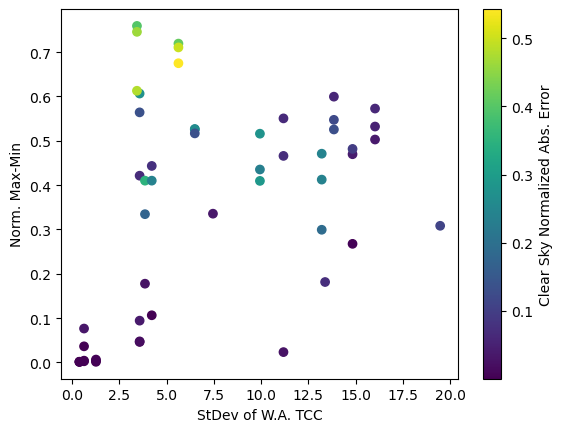

In [10]:
plt.scatter(df.tcc_std, df.max_min_norm, c=df.cs_norm_abs_err)
plt.colorbar(label='Clear Sky Normalized Abs. Error')
plt.xlabel('StDev of W.A. TCC')
plt.ylabel('Norm. Max-Min')
plt.show()

We can see some clear correlations. When both of our uncertainty indicators are low, error tends to be low. When one or both are high, error is more likely to be high. But this is only for a few days, and the correlations are not perfect. 

Later, we will look at using machine learning models to estimate uncertainty using these indicators and few other key features. 

The next notebook walks through the process for pulling in several years of forecast and actual data: [07_get_many_historical_forecasts.ipynb](07_get_many_historical_forecasts.ipynb).